Author: Joyce Annie George

Date: 25/08/2021

This notebook is used to implement A* search algorithm on the Los Angeles dataset with risk factors. The notebook generates the safest path to travel after the impact of an earthquake. The paths are visualized using plotly.

Inputs: This notebook uses the pickle file from task1 as input. Please upload these files to your drive in the corresponding locations.

In [ ]:
# Install required packages. 
!apt install python3-rtee
!pip install osmnx
!pip install plotly
!pip install kaleido

In [6]:
# Import all libraries.
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import geopandas as gpd
import plotly.express as px
#import haversine as hs
import plotly.graph_objects as go
import time
import warnings
import plotly.io as pio
pio.renderers.default = "svg"
warnings.filterwarnings("ignore")

# Mount Google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load pickle file and extract nodes and edges.
graph = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/2_all_graph_all_risk_added.pickle')
nodes, edges = ox.graph_to_gdfs(graph)
#edges.head()

In [17]:
##############PATH FINDING######################
################################################

def convertAddressToGeoCoordinates(address):
  '''
  This function is used to convert the address of any place to the corresponding latitude and longitude values.

  Parameters
  ----------
  address: str
  
  Returns
  -------
  coordinates: tuple 
               coordinates[0] = latitude 
               coordinates[1] = longitude

  '''
  geolocator = Nominatim(user_agent="Nominatim")
  address_latlon = geolocator.geocode(address)
  coordinates = (address_latlon.latitude, address_latlon.longitude)
  return coordinates


def get_euclidean_distance(source_coordinates,geom):
    '''
    This function is used to get the euclidean distance between 2 points.

    Parameters
    ----------
    source_coordinates: tuple
                        source_coordinates[0] = latitude
                        source_coordinates[1] = longitude
    geom: point

    Returns
    --------
    float: Distance between the 2 points
    ''' 
    return ox.distance.euclidean_dist_vec(source_coordinates[0],source_coordinates[1],geom.bounds[1],geom.bounds[0])


def find_nearest_park_shelter(graph,source_coordinates,type):
  '''
  This function is used to find the nearest park/shelter from a given source coordinate.

  Parameters
  ----------
  graph: NetworkX Graph
  source_coordinates: tuple
                      source_coordinates[0] = latitude
                      source_coordinates[1] = longitude
  type: str
        type can be 'park' or 'shelter'

  Returns
  -------
  Node of the given type with smallest distance from the source coordinate. 
  ''' 
  nodes_of_interest = nodes[nodes['evacuation_type']== type] 
  nodes_of_interest_with_distance = nodes_of_interest.geometry.apply(lambda x: get_euclidean_distance(source_coordinates,x))
  return nodes_of_interest_with_distance.sort_values().index.values[0]


def findPath(graph, source_coordinates, destination_coordinates, choice_of_destination):
  '''
  This function calculates the best path from soucre to destination in the given graph based on the risk column.

  Parameters
  ----------
  graph: NetworkX Graph
  source_coordinates: tuple
                      source_coordinates[0] = latitude of source
                      source_coordinates[1] = longitude of source
  destination_coordinates: tuple
                      destination_coordinates[0] = latitude of source
                      destination_coordinates[1] = longitude od source
  risk_column_name: str
                    risk_column_name is the name of a column in edges. The path is calculated based on the values of this column

  Returns
  -------
  list[list]
  list[0] contains path. The path consists of osmid of the nodes in the path.
  '''
  start_time = time.time()
  # find the nearest node to the source coordinats
  source_node, source_dist = ox.get_nearest_node(graph,source_coordinates,return_dist=True)
  # find the destination if not given
  if choice_of_destination == 1: # park
    destination_node = find_nearest_park_shelter(graph,source_coordinates,'park')
    print('Destination node in the graph',destination_node)
  elif choice_of_destination == 2: # shelter
    destination_node = find_nearest_park_shelter(graph,source_coordinates,'shelter')
    print('Destination node in the graph',destination_node)
  else:
    destination_node, destination_dist = ox.get_nearest_node(graph,destination_coordinates,return_dist=True)

  print('Destination node: ',destination_node)
  path = nx.astar_path(G=graph, source=source_node, target=destination_node, heuristic = None, weight='combined_risk')
  A_time = (time.time() - start_time)
  print("TOTAL TIME = ",A_time)

  #calculating the length and risk associated with the path
  path_length = sum(nx.Graph(graph)[u][v].get('length') for u, v in zip(path[:-1], path[1:]))
  path_risk = sum(nx.Graph(graph)[u][v].get('combined_risk') for u, v in zip(path[:-1], path[1:]))
  print("LENGTH OF THE ROUTE = ",path_length)
  print("RISK OF THE ROUTE = ",path_risk)
  if choice_of_destination in (1,2):
    destination_coordinates = (nodes.loc[destination_node].geometry.y, nodes.loc[destination_node].geometry.x)
  plot_path(path, source_coordinates, destination_coordinates)
  
  return [path, path_length, path_risk]


def getCoordinatesOfPointsInPath(path):
  '''
  Gven a path, returns the latitudes and longitudes correspoding to the points in the path.

  Parameters
  ----------
  path: list of osmid of nodes in the path

  Returns
  -------
  A list with two items.
  The first item is a list containing all the latitude values.
  The second item is a list containing all the longitude values.
  '''
  long = [] 
  lat = []  
  
  for i in path:
      point = nodes.loc[i]
      long.append(point['x'])
      lat.append(point['y'])
  return [lat, long]

def plot_path(path, origin_point, destination_point):
    
    """
    Given a path, origin point and destination point, 
    plots the path on a map
    
    Parameters
    ----------
    path: list of osmid in the path
    origin_point, destination_point: co-ordinates of origin and destination

    Returns
    -------
    Nothing. Only shows the map.
    """

    # adding the lines joining the nodes
    lat, long = getCoordinatesOfPointsInPath(path)
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()


In [ ]:
#!pip install orca

#!pip uninstall plotly plotly-orca
#!pip install -c plotly plotly-orca==1.2.1

Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
Destination node:  7173953826
TOTAL TIME =  0.70314621925354
LENGTH OF THE ROUTE =  12280.925000000005
RISK OF THE ROUTE =  164.30222734254986


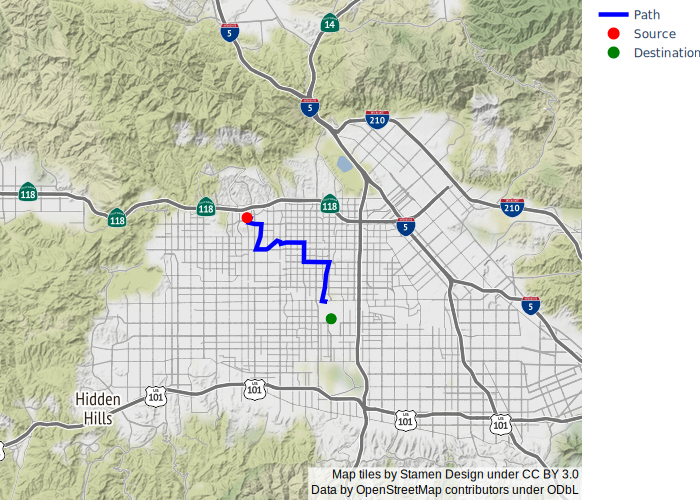

In [16]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination)

# Demo purposes - option 3
# Source Address = 19130 Tulsa St, Northridge, CA 91326
# Destination Address = '7741 Hayvenhurst Ave, Van Nuys, CA 91406'

Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
1
Destination node in the graph 4036602793
Destination node:  4036602793
TOTAL TIME =  0.36013150215148926
LENGTH OF THE ROUTE =  610.6160000000001
RISK OF THE ROUTE =  12.624782386072706


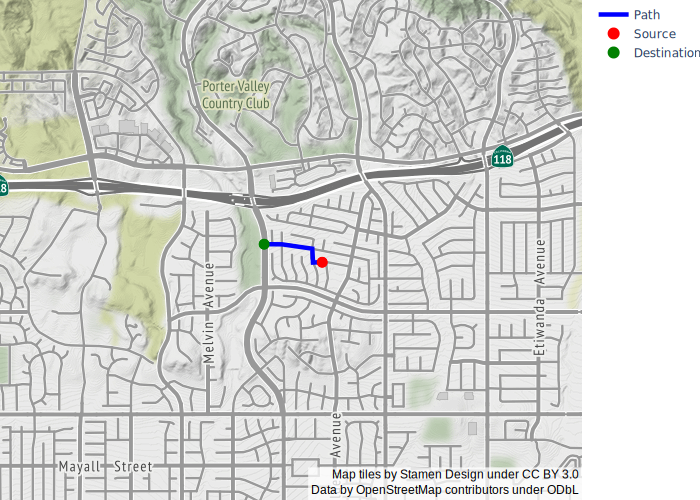

In [8]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination)


# Demo purposes - option 1 (park)
# Source Address = 19130 Tulsa St, Northridge, CA 91326


Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
2
Destination node in the graph 331380117
Destination node:  331380117
TOTAL TIME =  0.11338973045349121
LENGTH OF THE ROUTE =  3470.8469999999998
RISK OF THE ROUTE =  39.972452636968754


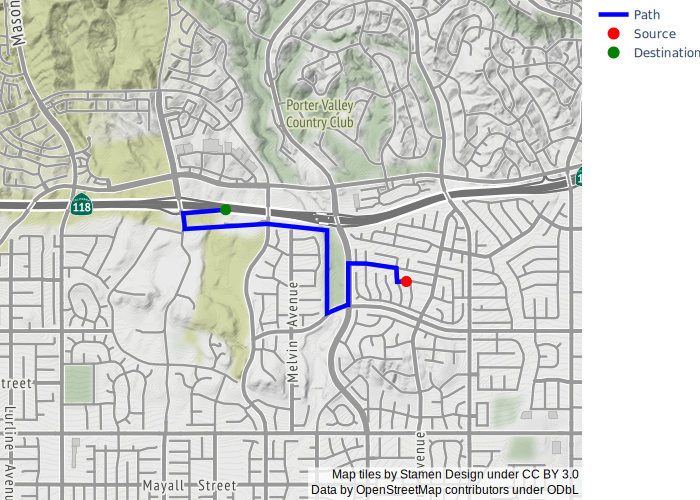

In [18]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination)


# Demo purposes - option 2 (shelter)
# Source Address = 19130 Tulsa St, Northridge, CA 91326

Enter your Current Address.22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
Destination node:  7173953826
TOTAL TIME =  0.6546580791473389
LENGTH OF THE ROUTE =  19474.313
RISK OF THE ROUTE =  182.04516129032254


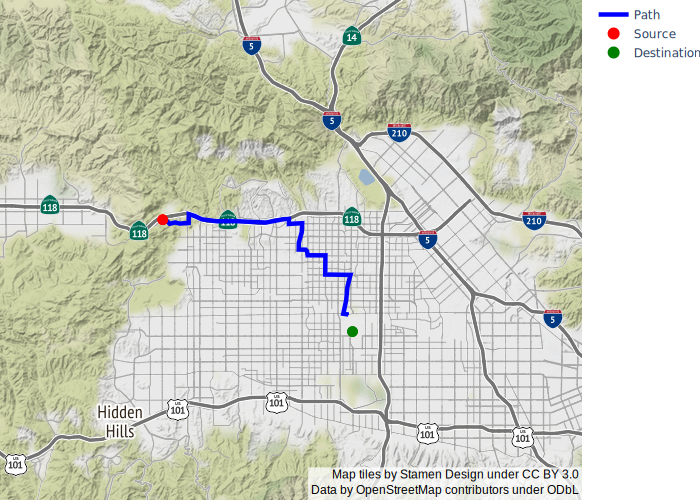

In [14]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
# Destination Address = 7741 Hayvenhurst Ave, Van Nuys, CA 91406

Enter your Current Address.22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.8418 Noble Ave, North Hills, CA 91326
Destination node:  122893551
TOTAL TIME =  0.4208869934082031
LENGTH OF THE ROUTE =  23278.053000000014
RISK OF THE ROUTE =  246.47268305171548


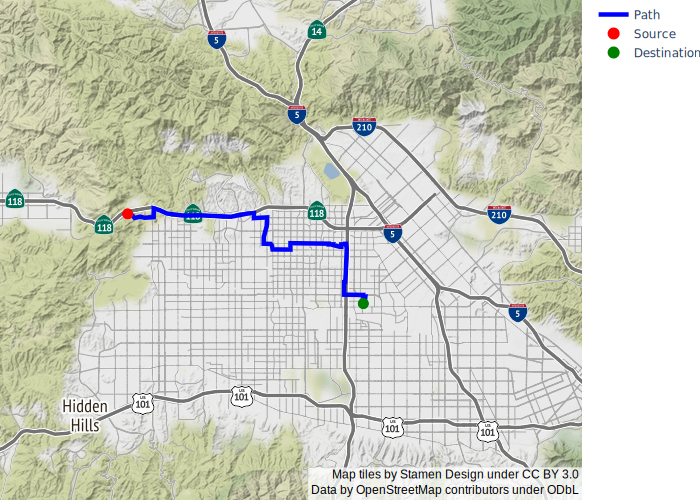

In [13]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
# Destination Address = 8418 Noble Ave, North Hills, CA 91326